<a href="https://colab.research.google.com/github/Samarth-991/Computer-vision/blob/main/CycleGAN_for_image2image_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CycleGAN 
The notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks. ](https://arxiv.org/abs/1611.07004)
Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.

This approach is effective at synthesizing photos from label maps, reconstructing objects from edge maps, and colorizing images, among other tasks.

In [11]:
import tensorflow as tf
import os
import cv2
import imageio
import matplotlib
import time
import gc 
import numpy as np
from tensorflow.keras.preprocessing import image
from glob import glob
from matplotlib import pyplot as plt
from IPython import display

## Load the Dataset - link

In [3]:
# If data is not present
# !wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/maps.tar.gz
# !tar -xvf /content/maps.tar.gz

# Customized Data Path 
# ! unzip  /content/drive/MyDrive/Colab_Notebooks/GAN_networks/aug_data.zip
# ! rm -rf /content/logs
Aug_data_path= '/content/aug_data'

In [5]:
train_path= Aug_data_path
train_imgs = [os.path.join(Aug_data_path,imgname) for imgname in os.listdir(train_path)]
print("training images",len(train_imgs))

def load(image_file):
    img = image.load_img(image_file,target_size=(IMG_HEIGHT,IMG_WIDTH))
    img = image.img_to_array(img)
    w = img.shape[1]
    w = w//2
    real_image = img[:, w:, :]
    input_image = img[:, :w, :]

    return input_image, real_image

training images 420


(512, 512, 3)


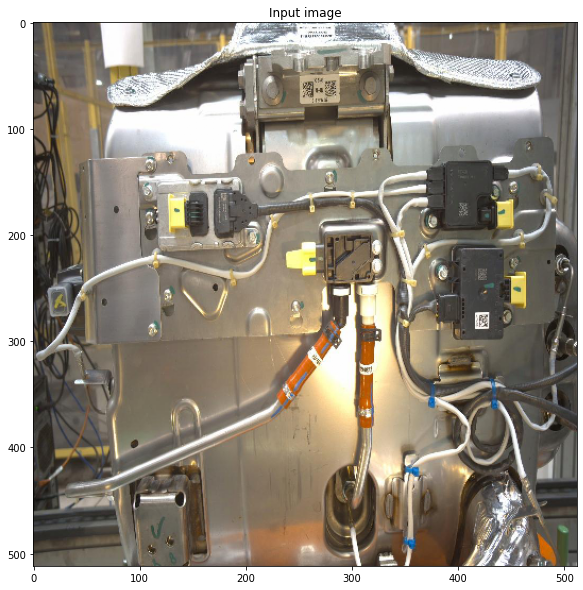

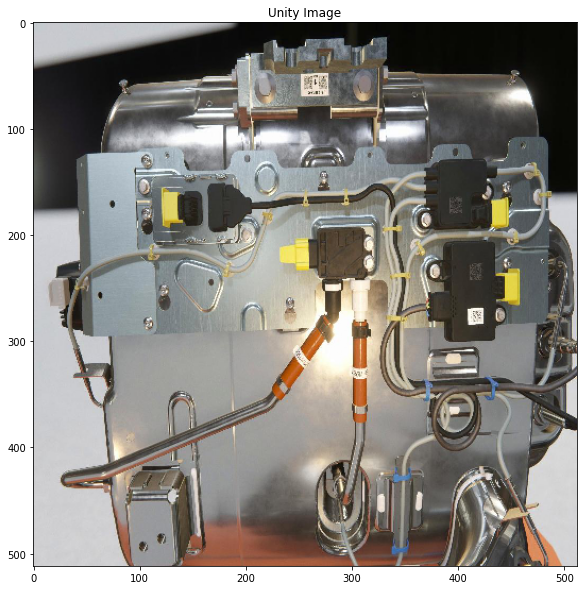

In [6]:
inp, re = load(train_imgs[np.random.randint(0,len(train_imgs))])
# casting to int for matplotlib to show the image
plt.figure(figsize=(10,10))
plt.title('Input image')
plt.imshow(inp/255.0)
# real Images 
plt.figure(figsize=(10,10))
plt.title('Unity Image')
plt.imshow(re/255.0)
print(inp.shape)

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 255.0) - 1
  real_image = (real_image / 255.0) - 1

  return input_image, real_image

## Pre-process images
1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally


In [8]:
# Define Hyper Parameters 
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_SHAPE = (512,512)

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_SHAPE[0], IMG_SHAPE[1])
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_dataset(train_imgs,train_path):
    src_imgs=list()
    tar_imgs =list()
    for imgs in train_imgs:
        filename =imgs
        in_img , rl_img = load_image_train(filename)
        src_imgs.append(in_img)
        tar_imgs.append(rl_img)
    src_imgs = np.asarray(src_imgs)
    tar_imgs = np.asarray(tar_imgs)
    return [src_imgs,tar_imgs]

In [10]:
src_images, tar_images = load_dataset(train_imgs,train_path)
print('Loaded: source Image {} \n Target Image Shape {}'.format( src_images.shape, tar_images.shape))

dataset = [src_images,tar_images]

Loaded: source Image (420, 512, 512, 3)  Target Image Shape (420, 512, 512, 3)


## Build the Discriminator

1. The Discriminator is a PatchGAN.
2. Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
3. The shape of the output after the last layer is (batch_size, 30, 30, 1)
4. Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
5. Discriminator receives 2 inputs.
6. Input image and the target image, which it should classify as real.
7. Input image and the generated image (output of generator), which it should classify as fake.
8. Concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))


In [12]:
from tensorflow.keras.layers import Concatenate,Conv2D,BatchNormalization,LeakyReLU,Input,Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [13]:
discriminator = define_discriminator(image_shape=[IMG_SHAPE[0],IMG_SHAPE[1],3])
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

### Build the Generator

1. The architecture of generator is a modified U-Net.
2. Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
3. Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
4. There are skip connections between the encoder and decoder (as in U-Net).


In [14]:
from tensorflow.keras.layers import Conv2DTranspose,Dropout
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g
 
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g
 
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [15]:
generator = define_generator(image_shape=(IMG_SHAPE[0],IMG_SHAPE[1],3))
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Define Cyclic GAN Network : Combined Generator and Doscriminator models

In [21]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

gan_model = define_gan(generator, discriminator, (IMG_SHAPE[0],IMG_SHAPE[1],3))

## Define Optimizers and Checkpoints for generator and Discriminator

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate functions for Fake and Real images 

In [22]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

### Define Training Function for Cyclic GAN Networks

In [29]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print("Running {} steps ".format(n_steps))
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
   
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance and generate images 
        if i%100 == 0:
            #checkpoint.save(file_prefix=checkpoint_prefix)
            print("Step {} Disc loss real sample {:.3f} Disc Loss predicted {:.3f} generator loss {:.3f}".format(i,d_loss1,d_loss2,g_loss))
            #print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
            generate_images(g_model, X_realA, X_realB,iter=i)
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

def generate_images(model, test_input,tar,iter=0,save_img=None):
    prediction = model(test_input, training=True)
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    in_img = np.asarray(test_input[0] * 0.5 + 0.5)
    gt_img = np.asarray(tar[0]*0.5+0.5)
    pd_img = np.asarray(prediction[0]*0.5+0.5)

    final_img = cv2.hconcat([in_img,gt_img,pd_img])
    final_img = final_img.astype(np.uint8)
    if save_img:
        imageio.imwrite(os.path.join(save_img,'image_'+str(iter)+'.png'),final_img)
    
    for i in range(3):
        fig = plt.figure(figsize=(20, 20))
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        img = np.asarray(display_list[2] * 0.5 + 0.5)
        img = img.astype(np.uint8)

## Model evaluation 

In [26]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

## Summary writer to view logs 

In [27]:
import datetime
log_dir="/content/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

#docs_infra: no_execute
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

Loaded training Data (420, 512, 512, 3) Target Data(420, 512, 512, 3)
Running 6000 steps 
Step 0 Disc loss real sample 0.068 Disc Loss predicted 0.412 generator loss 7.278


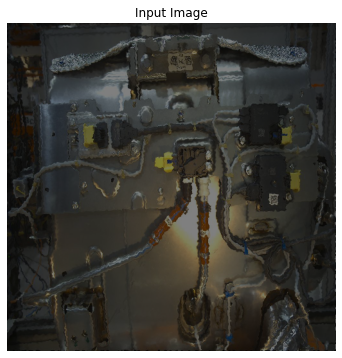

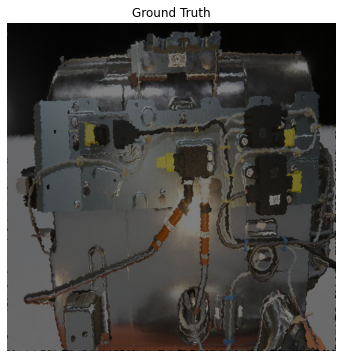

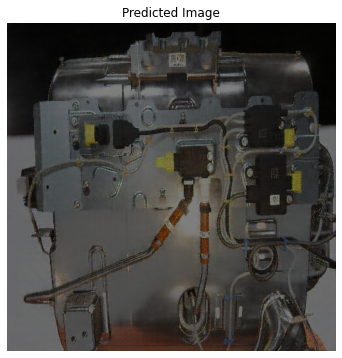

In [ ]:
# remove the checkpoints if created previously 
! rm -rf '/content/training_checkpoints'
! rm -rf '/content/logs'

print('Loaded training Data {} Target Data{}'.format(dataset[0].shape,dataset[1].shape))
# train model
train(discriminator, generator, gan_model, dataset,n_batch=7)